![image.png](https://i.imgur.com/a3uAqnb.png)

In [6]:
from IPython.display import clear_output

In [ ]:

# Download the required libraries (needed when running outside colab where the environment doesn't come pre-loaded with libraries)

# %pip install torch
# %pip install torchvision
# %pip install matplotlib

clear_output()

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import MNIST
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision import transforms

from torch.utils.data import DataLoader
from torch.optim import Adam

import matplotlib.pyplot as plt

# Sign Langauge Problem:

## Intution: The AI is so powrful and important because of its various applications on most if not all the different fields. As a result, we want to help in solving the issue of not understanding sign languages.

## - This notebook contains a detailed implementaiton of a NN uisng Pytorch.

### 1. Data set Details:

- The provided data set is ArASL (Arabic Alphabets Sign Language Dataset). It is as its name says, an arabic sighn langauge for Arabic alphabet. It has a total of 54049 images and their corrssponding labels.

### 2. Size of data:
- Length of train_dataset is 43239,
- Length of val_dataset is 10810

### 3. Labels representations:
- Each sample has a label, which can be one of the 32 classes.
It consist of 32 classes for the alphabet.
- The classes values are integers from 0 up to 31.


### 4. The mapping details:

- Each number represents a charcter. You can see the dictionary in the variable "mapping".

<br/>
-- You can see the mapping in the following:

0: 'seen', 1: 'zay', 2: 'aleff', 3: 'dal', 4: 'ta', 5: 'yaa', 6: 'fa', 7: 'ya', 8: 'khaa', 9: 'nun', 10: 'ha', 11: 'toot', 12: 'taa', 13: 'ra', 14: 'kaaf', 15: 'jeem', 16: 'laam', 17: 'la', 18: 'dhad', 19: 'dha', 20: 'waw', 21: 'meem', 22: 'al', 23: 'sheen', 24: 'haa', 25: 'thaa', 26: 'saad', 27: 'ghain', 28: 'ain', 29: 'thal', 30: 'gaaf', 31: 'bb'

### 5. Refrence:
Latif, G., Mohammad, N., Alghazo, J., AlKhalaf, R., & AlKhalaf, R. (2019). ARASL: Arabic Alphabets Sign Language Dataset. *Data in Brief*, 23, 103777. https://doi.org/10.1016/j.dib.2019.103777

## Downloading the dataset

### Run the following cells to download the MNIST dataset.

In [8]:
!gdown https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded

Downloading...
From: https://data.mendeley.com/public-files/datasets/y7pckrw6z2/files/1efa0d6b-4d7f-4f58-9584-08f0488279ee/file_downloaded
To: /content/file_downloaded
100% 66.2M/66.2M [00:04<00:00, 16.4MB/s]


In [9]:
import os

def delete_folder(folder_path):
    try:
        # Get the list of files and subdirectories in the folder
        for item in os.listdir(folder_path):
            item_path = os.path.join(folder_path, item)

            # If it's a file, delete it
            if os.path.isfile(item_path):
                os.remove(item_path)
            # If it's a directory, recursively call delete_folder
            elif os.path.isdir(item_path):
                delete_folder(item_path)

        # Remove the empty folder
        os.rmdir(folder_path)
        print(f"Folder '{folder_path}' and its contents deleted successfully.")
    except FileNotFoundError:
        print(f"Folder '{folder_path}' not found.")
    except PermissionError:
        print(f"Permission error: Unable to delete folder '{folder_path}'.")
    except Exception as e:
        print(f"An error occurred: {e}")


delete_folder('ArASL_Database_54K_Final')

!unzip file_downloaded
clear_output()

## Just run these two cells. You do not need to explore them, but it would be a plus if you understand them.

In [10]:
import os

def rename_folders_and_create_mapping(folder_path):
    # Get the list of folders in the specified path
    folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

    # Create a mapping from original folder names to numbers
    folder_mapping = {folder: i for i, folder in enumerate(folders)}

    # Rename the folders in-place and store the original names in the mapping
    for original_folder, number in folder_mapping.items():
        new_folder_name = str(number)
        new_folder_path = os.path.join(folder_path, new_folder_name)

        # Rename the folder
        os.rename(os.path.join(folder_path, original_folder), new_folder_path)

    return folder_mapping

folder_path = 'ArASL_Database_54K_Final'

# Create the folder mapping and rename folders
mapping = rename_folders_and_create_mapping(folder_path)

# Print the folder mapping
print("Folder Mapping:")
print(mapping)


Folder Mapping:
{'bb': 0, 'jeem': 1, 'sheen': 2, 'ain': 3, 'fa': 4, 'dha': 5, 'waw': 6, 'ha': 7, 'ta': 8, 'toot': 9, 'laam': 10, 'ra': 11, 'khaa': 12, 'yaa': 13, 'aleff': 14, 'thaa': 15, 'nun': 16, 'ghain': 17, 'dhad': 18, 'la': 19, 'dal': 20, 'saad': 21, 'kaaf': 22, 'zay': 23, 'seen': 24, 'haa': 25, 'al': 26, 'gaaf': 27, 'thal': 28, 'taa': 29, 'ya': 30, 'meem': 31}


In [11]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomDataset(Dataset):
    def __init__(self, root_folder, transform=None, target_size=(48, 48)):
        self.root_folder = root_folder
        self.transform = transform
        self.target_size = target_size

        # Get the list of image files
        self.image_files = []
        self.image_labels = []

        for root, dirs, files in os.walk(root_folder):
            for file in files:
                if file.lower().endswith('.jpg'):
                    self.image_files.append(os.path.join(root, file))
                    self.image_labels.append(int(os.path.basename(root)))

    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        label = self.image_labels[idx]

        # Convert label to tensor
        # print("Label", label, type(label))
        label = torch.tensor(label)

        # Open the image
        with Image.open(img_path) as img:
            # Convert the image to grayscale
            img = img.convert('L')

            # Resize the image
            img = img.resize(self.target_size)

            # Apply additional transformations if specified
            if self.transform:
                img = self.transform(img)

            return (img, label)

# Define the root folder and output folder
root_folder_path = 'ArASL_Database_54K_Final'


# Define transformations (resize to 28x28 and convert to tensor)
data_transform = transforms.Compose([
    # transforms.Resize((48, 48)),
    transforms.ToTensor(),
])

# Create an instance of the custom dataset
custom_dataset = CustomDataset(root_folder_path, transform=data_transform)

from torch.utils.data import random_split

# Define the size of the training and validation sets
total_size = len(custom_dataset)
train_size = int(0.8 * total_size)  # 80% for training
val_size = total_size - train_size  # 20% for validation

# Split the dataset
train_dataset, val_dataset = random_split(custom_dataset, [train_size, val_size])

mapping = {v:k for k,v in mapping.items()}

## Exploring the data

#### Here is the mapping for each class and its encoding. In addition to the train_dataset and val_dataset

In [12]:
train_dataset # Contains the training ArASL_Database_54K_Final dataset (80%)

val_dataset  # Contains the validating ArASL_Database_54K_Final dataset (20%)


print("The mapping between the letters and the encoding: \n", mapping)

# Check the lengths of train_dataset and val_dataset.
print(len(train_dataset))
print(len(val_dataset))

The mapping between the letters and the encoding: 
 {0: 'bb', 1: 'jeem', 2: 'sheen', 3: 'ain', 4: 'fa', 5: 'dha', 6: 'waw', 7: 'ha', 8: 'ta', 9: 'toot', 10: 'laam', 11: 'ra', 12: 'khaa', 13: 'yaa', 14: 'aleff', 15: 'thaa', 16: 'nun', 17: 'ghain', 18: 'dhad', 19: 'la', 20: 'dal', 21: 'saad', 22: 'kaaf', 23: 'zay', 24: 'seen', 25: 'haa', 26: 'al', 27: 'gaaf', 28: 'thal', 29: 'taa', 30: 'ya', 31: 'meem'}
43239
10810


In [13]:
batch_size = 64 # To group each k samples together.

# DataLoaders simplify the job of grouping the samples into batches.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)  # no need to shuffle validation data

## Let's visualize an image.

The image label: 31 meem


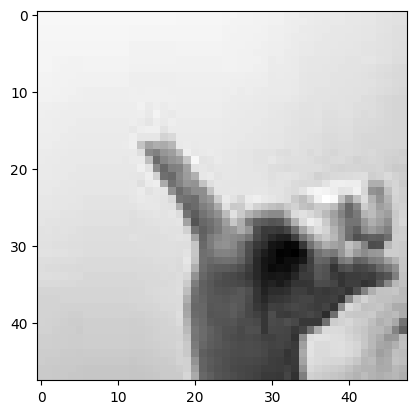

In [14]:
random_img_idx = 30 # Write any random index (between 0 and 59999)

image = train_dataset[random_img_idx][0]  # 0 for image part in (image, label) tuple.
label = train_dataset[random_img_idx][1]  # 1 for label part

print("The image label:", label.item(), mapping[label.item()])

plt.imshow(image.reshape(image.shape[1], image.shape[1]), cmap='gray')

### Display 10 different images

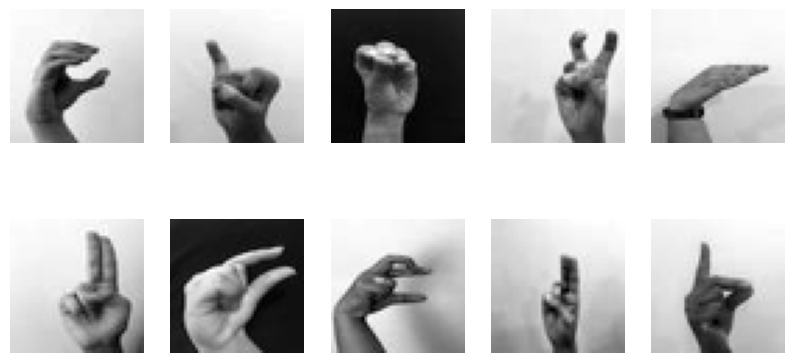

Shape of one image tensor: torch.Size([1, 48, 48])


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of training data
data_iter = iter(train_loader)
images, _ = next(data_iter)  # Labels are ignored in Autoencoder

# Show images
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    img = images[i].squeeze(0)  # Remove channel dimension (1, 28, 28) → (28, 28)

    ax.imshow(img.numpy(), cmap="gray")
    ax.axis("off")

plt.show()

# Show shape of one image
print("Shape of one image tensor:", images[0].shape)  # Expected: (1, 28, 28)


### Create a an Autoencoder model to compress and recompress images.
- Display the loss of the training.
- Show some original images with their reconstructed ones.
- Generate new images.

In [17]:
class SignLang_AutoEncoder(nn.Module):
    def __init__(self, encoding_dim=8):
        super(SignLang_AutoEncoder, self).__init__()

        # Encoder (Feature Extraction)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),  # (48x48) → (24x24)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.Conv2d(16, 32, 3, 2, 1), # (24x24) → (12x12)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 2, 1), # (12x12) → (6x6)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Flatten(),  # Flatten to vector
            nn.Linear(64 * 6 * 6, encoding_dim),
            nn.BatchNorm1d(encoding_dim),
            nn.Tanh(),
        )

        # Decoder (Reconstruction)
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64 * 6 * 6),
            nn.BatchNorm1d(64 * 6 * 6),
            nn.LeakyReLU(),
            nn.Unflatten(1, (64, 6, 6)),  # Reshape back
            nn.ConvTranspose2d(64, 32, 3, 2, 1, output_padding=1),  # (6x6) → (12x12)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),  # (12x12) → (24x24)
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1),  # (24x24) → (48x48)
            nn.Sigmoid(),  # Normalize pixel values
        )

    def forward(self, x):
        encoder_out = self.encoder(x)
        decoder_out = self.decoder(encoder_out)
        return encoder_out, decoder_out

In [18]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0

    for images, _ in tqdm(dataloader):  # Ignore labels since Autoencoders don't use them
        images = images.to(device)

        _, reconstructions = model(images)  # Forward pass (encoder + decoder) model.forward(images)
        loss = criterion(reconstructions, images)  # Compute reconstruction loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss  # No accuracy since it's not classification


In [21]:
import torch.optim as optim


# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SignLang_AutoEncoder(encoding_dim=64).to(device)

# Print model summary
print(model)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Measure reconstruction quality
optimizer = optim.AdamW(model.parameters(), lr=1e-4)  # AdamW optimizer

SignLang_AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=2304, out_features=64, bias=True)
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=2304, bias=True)
    (1): BatchNorm1d(2304, eps=1e-05, m

In [22]:
num_epochs = 5 # Number of epochs

# Store losses for plotting
train_losses = []

# Training loop
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss = {train_loss:.4f}")

100%|██████████| 676/676 [01:24<00:00,  8.04it/s]


Epoch 1/5, Loss = 0.0472


100%|██████████| 676/676 [01:24<00:00,  8.03it/s]


Epoch 2/5, Loss = 0.0127


100%|██████████| 676/676 [01:22<00:00,  8.23it/s]


Epoch 3/5, Loss = 0.0078


100%|██████████| 676/676 [01:20<00:00,  8.35it/s]


Epoch 4/5, Loss = 0.0065


100%|██████████| 676/676 [01:22<00:00,  8.24it/s]

Epoch 5/5, Loss = 0.0059


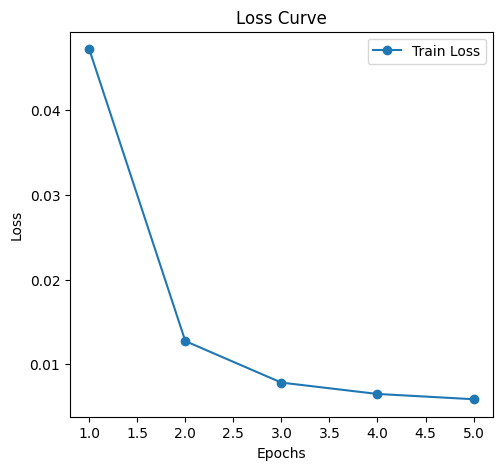

In [23]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.show()

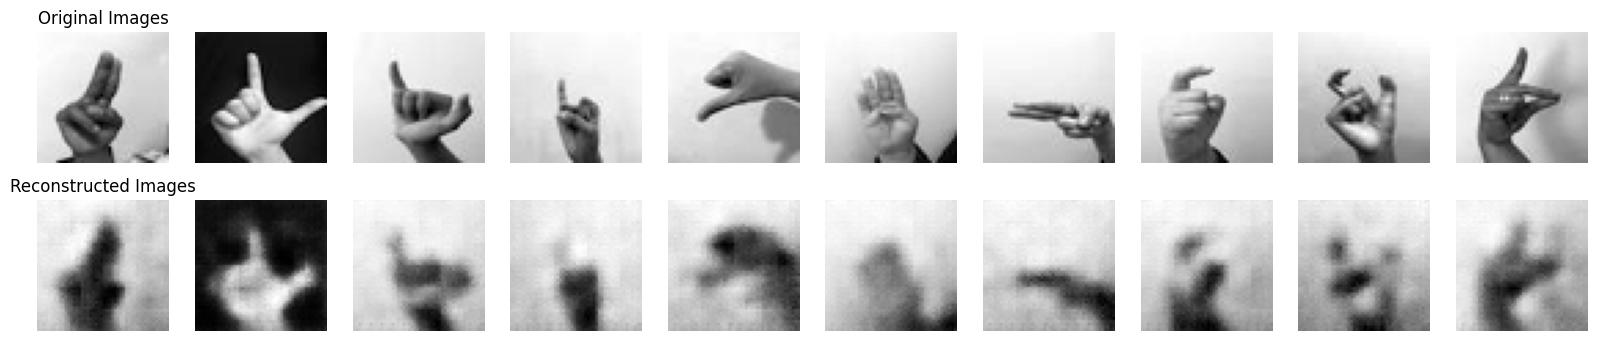

In [24]:
import matplotlib.pyplot as plt

# 🔹 Function to Display Original vs. Reconstructed Images
def show_original_vs_reconstructed(model, dataloader, device, num_images=10):
    model.eval()  # Set to evaluation mode

    # Get a batch of images
    images, _ = next(iter(dataloader))
    images = images[:num_images].to(device)  # Select 'num_images' samples

    # Get reconstructed images
    with torch.no_grad():
        _, reconstructions = model(images)
    reconstructions = reconstructions.cpu()

    # Plot original vs reconstructed images
    fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))

    for i in range(num_images):
        # Original images (Top row)
        axes[0, i].imshow(images[i].cpu().squeeze(), cmap="gray")
        axes[0, i].axis("off")

        # Reconstructed images (Bottom row)
        axes[1, i].imshow(reconstructions[i].squeeze(), cmap="gray")
        axes[1, i].axis("off")

    axes[0, 0].set_title("Original Images", fontsize=12)
    axes[1, 0].set_title("Reconstructed Images", fontsize=12)
    plt.show()

# 🔹 Display Results
show_original_vs_reconstructed(model, train_loader, device)


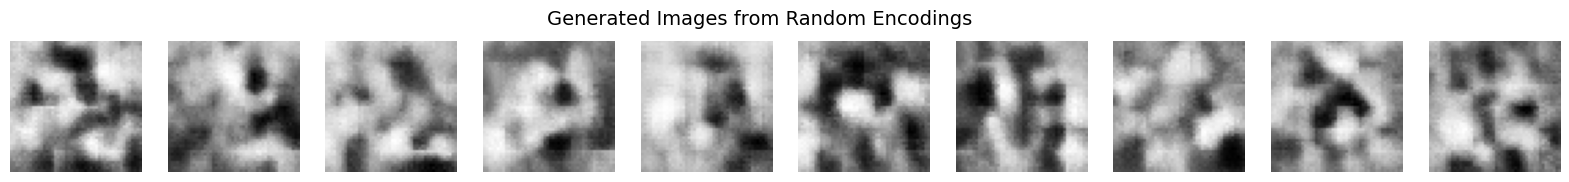

In [30]:
import matplotlib.pyplot as plt

# 🔹 Function to Generate Images
def generate_images(model, num_images=10, encoding_dim=8):
    model.eval()  # Set to evaluation mode

    # Generate random encodings from a uniform distribution in [-1,1]
    random_encodings = (torch.rand(num_images, encoding_dim).to(device) - 0.5) * 2

    # Pass through decoder to generate images
    with torch.no_grad():
        generated_images = model.decoder(random_encodings).cpu()

    # Reshape images
    generated_images = generated_images.view(-1, 48, 48)  # Convert to 2D shape

    # Plot generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap="gray")
        ax.axis("off")

    plt.suptitle("Generated Images from Random Encodings", fontsize=14)
    plt.show()

# 🔹 Generate & Display Images
generate_images(model, num_images=10, encoding_dim=64)


# Contributed by: Hassan Alsayhah

![image.png](https://i.imgur.com/a3uAqnb.png)